In [1]:
import gpxpy
import mplleaflet
import pykalman
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

%load_ext autoreload
%autoreload 2

# Reading a GPX file

In [2]:
with open('../gpx/3-laender-giro.gpx') as fh:
    gpx_file = gpxpy.parse(fh)

In [3]:
print("File has {} track(s).".format(len(gpx_file.tracks)))

File has 1 track(s).


In [4]:
print("Track has {} segment(s).".format(len(gpx_file.tracks[0].segments)))

Track has 1 segment(s).


## GPX segments can be easily converted to a Pandas dataframe

In [5]:
segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([{'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'time': p.time} for p in segment.points])
coords.set_index('time', drop=True, inplace=True)
coords.head()

ele        lat        lon
time                                             
2016-06-26 04:31:27  1343.0  46.889062  10.502119
2016-06-26 04:31:28  1343.0  46.889062  10.502119
2016-06-26 04:31:29  1343.0  46.889062  10.502119
2016-06-26 04:31:30  1344.0  46.889065  10.502119
2016-06-26 04:31:31  1345.0  46.889068  10.502121

## Plotting a segment

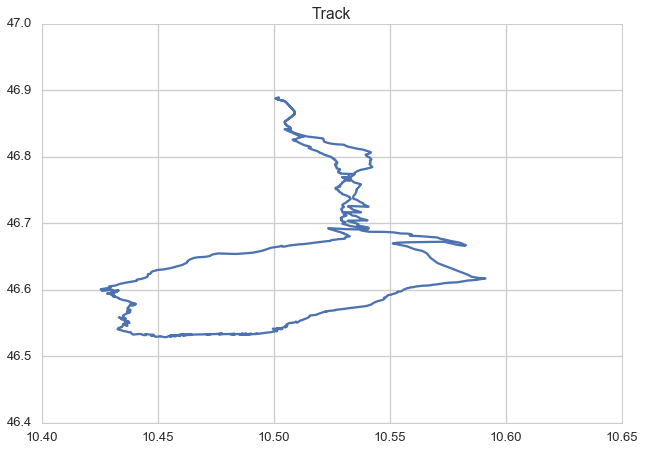

In [6]:
plt.plot(coords['lon'].values, coords['lat'].values)
plt.title("Track")

## Working with the elevation of a track

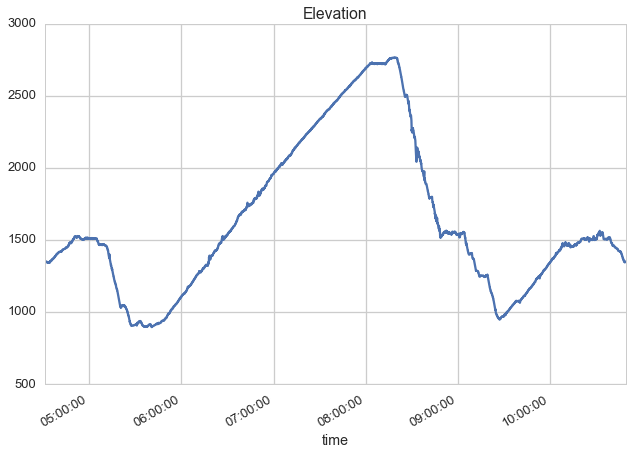

In [7]:
coords.ele.plot(title='Elevation')

### Let's assume the elevation data is missing

In [8]:
for point in segment.points:
    point.elevation = None

### Use srtm.py to add missing elevation data

In [9]:
import srtm

elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx_file, smooth=True)

In [10]:
coords['new_ele'] = [p.elevation for p in gpx_file.tracks[0].segments[0].points]

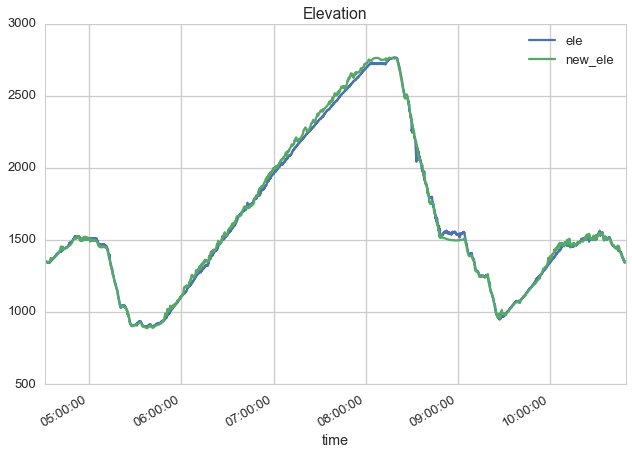

In [11]:
coords[['ele','new_ele']].plot(title='Elevation')

## Working with speeds

In [12]:
start_time, end_time = segment.get_time_bounds()
duration = end_time - start_time

In [13]:
average_speed = segment.length_3d() / duration.seconds * 3.6
print("Average speed is {:.2f} km/h".format(average_speed))

Average speed is 19.93 km/h


### Speed at specific points

In [14]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

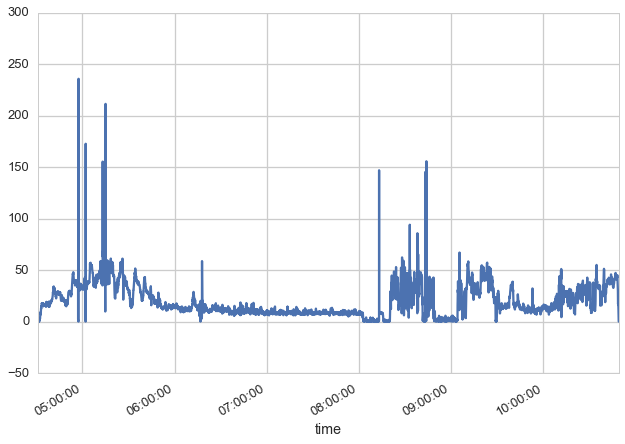

In [15]:
coords['speed'] = [p.speed for p in segment.points]
coords['speed'] *= 3.6
coords['speed'].plot()

In [16]:
coords['speed'].max()

235.81869835597354

### Huiii, up to 235 km/h, that's fast for bikecycle

## What about uphill and downhill distances?

In [17]:
segment.get_uphill_downhill()

UphillDownhill(uphill=5232.6028913648215, downhill=5232.602891364802)

### Can this be true??? Not really!!! We should apply a Kalman filter as shown later in notebook 4